# Test the annual and monthly CPI

- GLORYS monthly data is used
- Using the entire GLORYS period for better climatology

## Determine the Cold Pool Index (CPI)
- define the Cold Pool Domain
    - MAB domain and between 38N-41.5N and between 75W-68.5W
    - between 20m to 200m isobath
    - average bottom temperature was cooler than 10°C (and > 6?) between June and September from 1959 to 2022
    - slicing off north of 41N or west of 70W? (southern flank of Georges Bank)
    
- CPI calculation
    - 

In [1]:
import xarray as xr
import numpy as np

### Glorys

In [2]:
glorys_file = '/Projects/GLORYS/Monthlies/monolevel/bottomT.mon.mean.199301-202012.nc'
glorys_static_file = '/Projects/GLORYS/Statics/GLO-MFC_001_030_mask_bathy.nc'
ds = xr.open_mfdataset([glorys_file,glorys_static_file],chunks={'time':1})

In [24]:
ds = ds.drop_vars('mask')

In [25]:
ds

<xarray.Dataset>
Dimensions:     (longitude: 4320, latitude: 2041, time: 336, depth: 50)
Coordinates:
  * longitude   (longitude) float32 0.0 0.08333 0.1667 ... 359.8 359.8 359.9
  * latitude    (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * time        (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:0...
  * depth       (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    bottomT     (time, latitude, longitude) float32 dask.array<chunksize=(1, 2041, 4320), meta=np.ndarray>
    deptho      (latitude, longitude) float32 dask.array<chunksize=(2041, 4320), meta=np.ndarray>
    deptho_lev  (latitude, longitude) float32 dask.array<chunksize=(2041, 4320), meta=np.ndarray>
Attributes: (12/14)
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    ...                            ...
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...

- 20~200 meter mask

In [4]:
da_mask_depth = ds.deptho.where((ds.deptho>20.)&(ds.deptho<200.),other=np.nan)

In [5]:
da_mask_depth = xr.where(da_mask_depth.notnull(),x=1,y=np.nan)

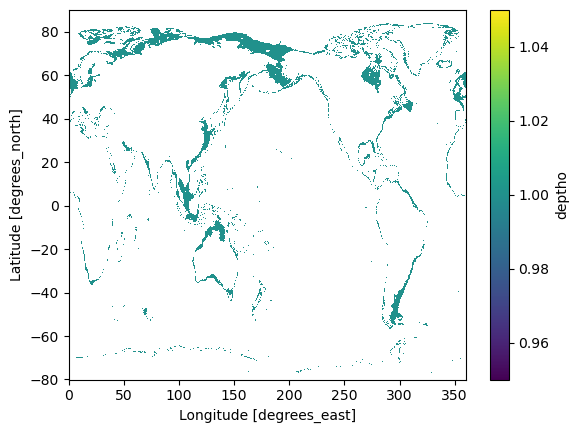

In [6]:
da_mask_depth.plot()

- average of bottom temperature during June-September from 1993-2021
    - annual mean than long-term mean
    - climatology long-term mean

In [47]:
da_bottomT_Jun2Sep = ds.bottomT.where((ds['time.month']>=6)&(ds['time.month']<=9),drop=True)
da_bottomT_mon_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.month']).mean(dim='time').compute()
da_bottomT_ann_ltm = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.year']).mean(dim='time').mean(dim='year').compute()
# da_mask_bottomT_mon = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.month']).mean(dim='time').compute()
# da_mask_bottomT_ann = da_bottomT_Jun2Sep.mean(dim='time').compute()

In [49]:
da_mask_bottomT_mon = xr.where(da_bottomT_mon_ltm<10, x=1, y=np.nan)
da_mask_bottomT_ann = xr.where(da_bottomT_ann_ltm<10, x=1, y=np.nan)

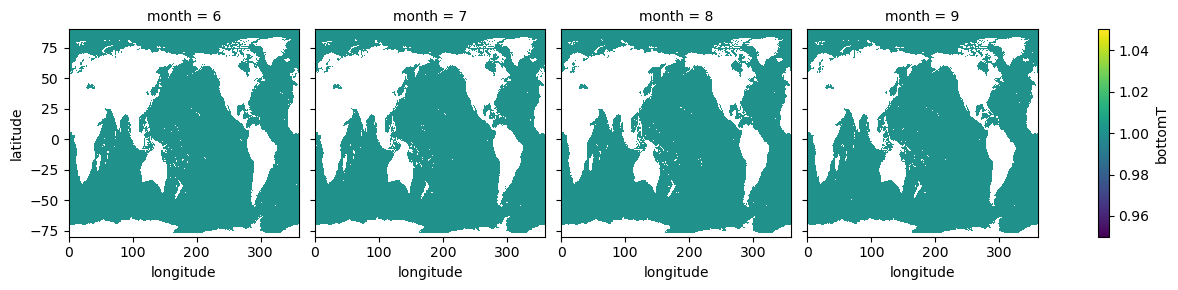

In [50]:
da_mask_bottomT_mon.plot(col='month')

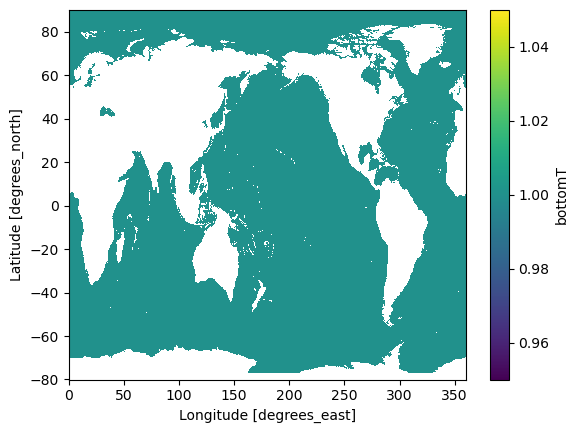

In [51]:
da_mask_bottomT_ann.plot()

### Mask from MOM6
- MAB
- remap to GLORYS
- regional crop

In [26]:
mab_file = '/Datasets.private/regional_mom6/masks/region_masks.nc'
static_file = '/Datasets.private/regional_mom6/ocean_static.nc'
# ds_static = xr.open_dataset(static_file)
ds_mask = xr.open_mfdataset([mab_file,static_file])
ds_mask = ds_mask.set_coords(['geolon','geolat','geolon_c','geolat_c','geolon_u','geolat_u','geolon_v','geolat_v'])

In [27]:
# regrid the mask to GLORYS
import xesmf as xe

# use xesmf to create regridder 
# !!!! regridded only suited for geolon and geolat to x and y
regridder = xe.Regridder(ds_mask.rename({'geolon':'lon','geolat':'lat'}), ds, "bilinear", unmapped_to_nan=True)


In [28]:
import numpy as np
da_mask = xr.where(ds_mask.MAB,x=1,y=np.nan)

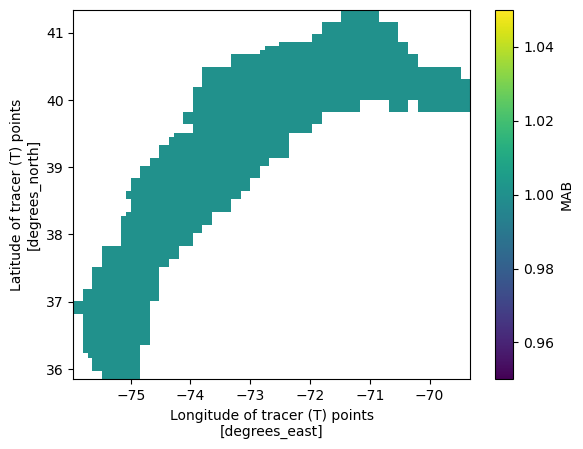

In [29]:
da_mask.where(da_mask==1,drop=True).plot(x='geolon',y='geolat')

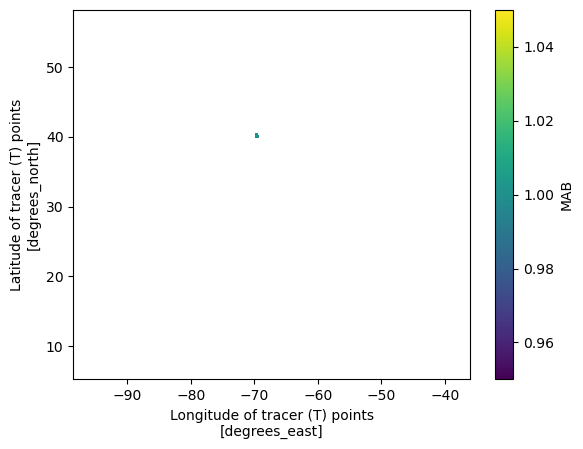

In [30]:
da_mask.where((da_mask.geolat>38)&(da_mask.geolat<41.5)&(da_mask.geolon<-68.5)&(da_mask.geolon>-75)).where((da_mask.geolat<41)&(da_mask.geolon>-70)).plot(x='geolon',y='geolat')

In [31]:
ds_mask

<xarray.Dataset>
Dimensions:       (yh: 845, xh: 775, time: 1, xq: 776, yq: 846)
Coordinates: (12/13)
    geolat        (yh, xh) float32 dask.array<chunksize=(845, 775), meta=np.ndarray>
    geolon        (yh, xh) float32 dask.array<chunksize=(845, 775), meta=np.ndarray>
  * xh            (xh) float64 -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * time          (time) datetime64[ns] 1980-01-01
  * xq            (xq) float64 -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
    ...            ...
    geolon_c      (yq, xq) float32 dask.array<chunksize=(846, 776), meta=np.ndarray>
    geolat_c      (yq, xq) float32 dask.array<chunksize=(846, 776), meta=np.ndarray>
    geolon_u      (yh, xq) float32 dask.array<chunksize=(845, 776), meta=np.ndarray>
    geolat_u      (yh, xq) float32 dask.array<chunksize=(845, 776), meta=np.ndarray>
    geolon_v      (yq, xh) float32 dask.array<chunksize=(846, 775), meta=np.ndarray>
    geolat_v      (yq, xh) float32 dask.array<chunksize=(846, 775), meta=np.ndarray>
Data variables: (12/30)
    areacello     (yh, xh) float32 dask.array<chunksize=(845, 775), meta=np.ndarray>
    MAB           (yh, xh) bool dask.array<chunksize=(845, 775), meta=np.ndarray>
    GOM           (yh, xh) bool dask.array<chunksize=(845, 775), meta=np.ndarray>
    SS            (yh, xh) bool dask.array<chunksize=(845, 775), meta=np.ndarray>
    GB            (yh, xh) bool dask.array<chunksize=(845, 775), meta=np.ndarray>
    SS_LME        (yh, xh) bool dask.array<chunksize=(845, 775), meta=np.ndarray>
    ...            ...
    dyCu          (yh, xq) float32 dask.array<chunksize=(845, 776), meta=np.ndarray>
    dxCv          (yq, xh) float32 dask.array<chunksize=(846, 775), meta=np.ndarray>
    dyCv          (yq, xh) float32 dask.array<chunksize=(846, 775), meta=np.ndarray>
    areacello_cu  (yh, xq) float32 dask.array<chunksize=(845, 776), meta=np.ndarray>
    areacello_cv  (yq, xh) float32 dask.array<chunksize=(846, 775), meta=np.ndarray>
    areacello_bu  (yq, xq) float32 dask.array<chunksize=(846, 776), meta=np.ndarray>
Attributes:
    NumFilesInSet:  1
    title:          NWA12_MOM6_v1.0
    grid_type:      regular
    grid_tile:      N/A

In [52]:
# perform regrid
#  https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html#Adaptive-masking
da_mask_regrid = regridder(da_mask, skipna=True, na_thres=0.25).compute()

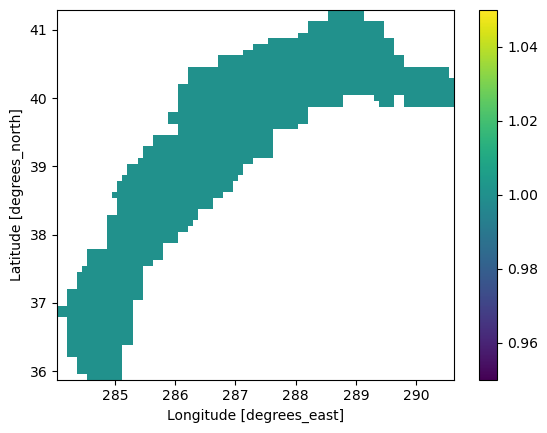

In [53]:
da_mask_regrid.where(da_mask_regrid==1,drop=True).plot()

In [54]:
da_mask_regrid_crop = (da_mask_regrid
    .where(
        (da_mask_regrid.latitude>=38)&
        (da_mask_regrid.latitude<=41.5)&
        (da_mask_regrid.longitude<=-68.5+360)&
        (da_mask_regrid.longitude>=-75+360),
        drop=True
    )
    .where(
        (da_mask_regrid.latitude<=41)&
        (da_mask_regrid.longitude>=-70+360),
        drop=True
    )
)

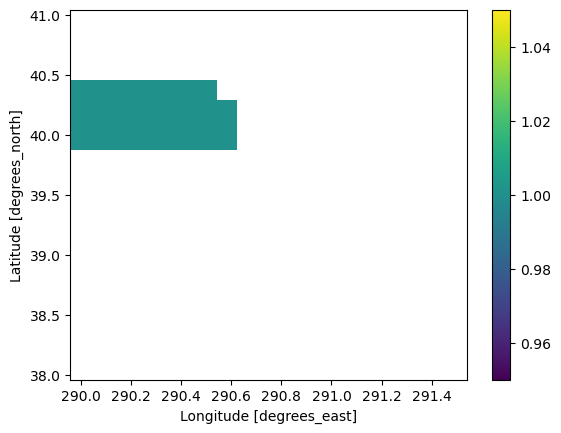

In [55]:
da_mask_regrid_crop.plot()

In [56]:
da_mask_regrid_crop.sum()

<xarray.DataArray ()>
array(54.)

In [57]:
da_mask_total_mon = da_mask_regrid_crop*da_mask_bottomT_mon*da_mask_depth
da_mask_total_ann = da_mask_regrid_crop*da_mask_bottomT_ann*da_mask_depth

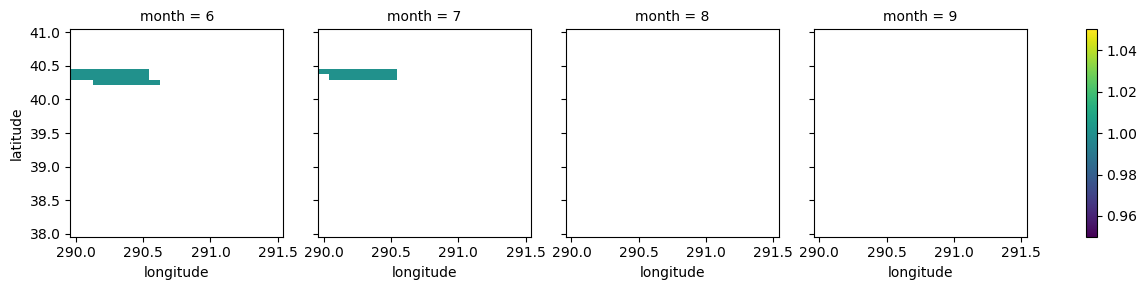

In [58]:
da_mask_total_mon.plot(col='month')

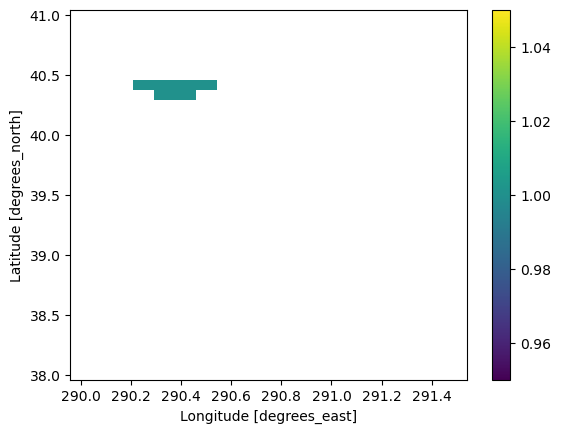

In [59]:
da_mask_total_ann.plot()

## GLORYS CPI

- calculate long-term mean and the month base time serie/annual mean based time series

In [60]:
da_bottomT_mon = da_bottomT_Jun2Sep
da_bottomT_ann = da_bottomT_Jun2Sep.groupby(da_bottomT_Jun2Sep['time.year']).mean(dim='time')

- calculate the anomaly based on monthly climatology/annual mean 
- apply mask (annual mask)

In [61]:
da_cpi_mon = ((da_bottomT_mon.groupby(da_bottomT_Jun2Sep['time.month'])-da_bottomT_mon_ltm)*da_mask_total_ann).compute()
da_cpi_ann = ((da_bottomT_ann-da_bottomT_ann_ltm)*da_mask_total_ann).compute()

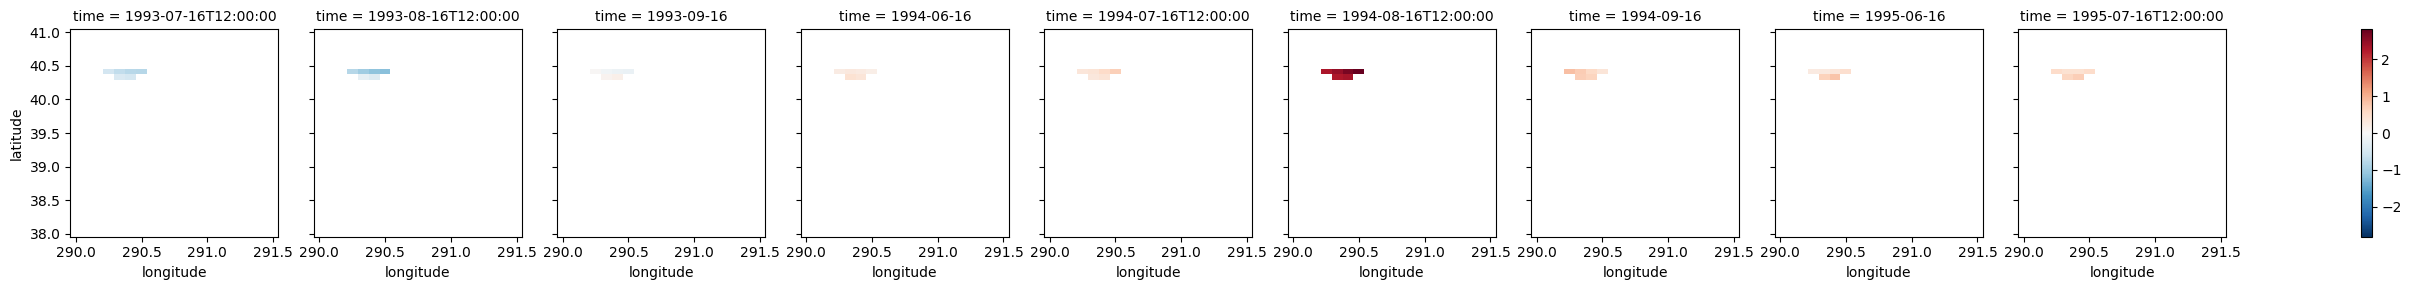

In [62]:
da_cpi_mon.isel(time=slice(1,10)).plot(col='time')

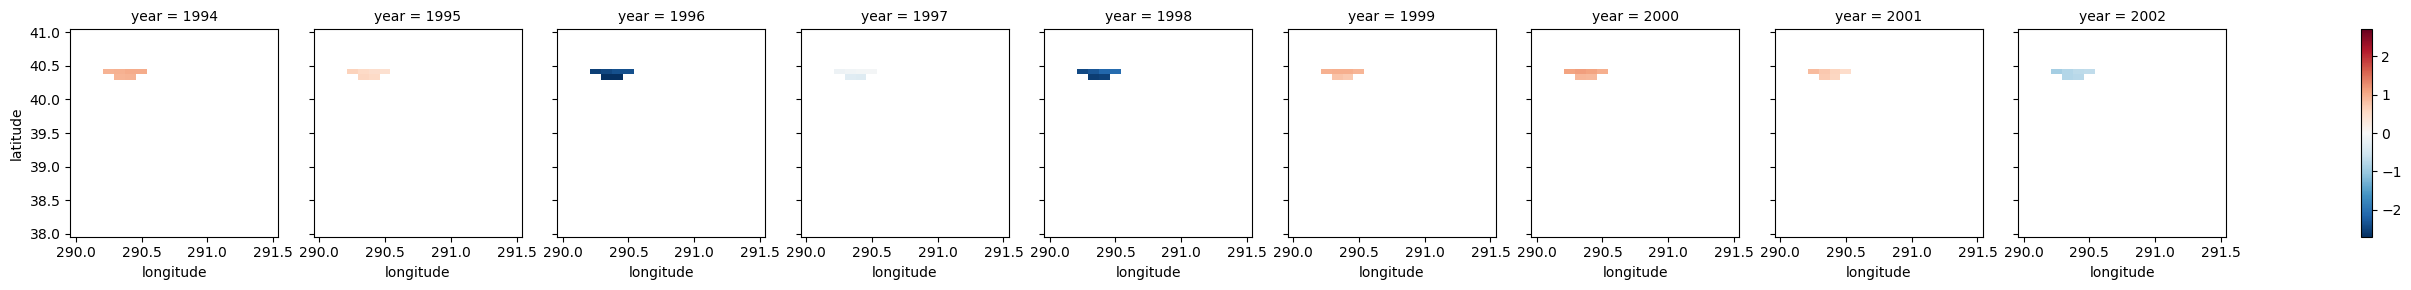

In [63]:
da_cpi_ann.isel(year=slice(1,10)).plot(col='year')

In [64]:
da_cpi_mon_mean = da_cpi_mon.mean(['latitude', 'longitude'])
da_cpi_ann_mean = da_cpi_ann.mean(['latitude', 'longitude'])

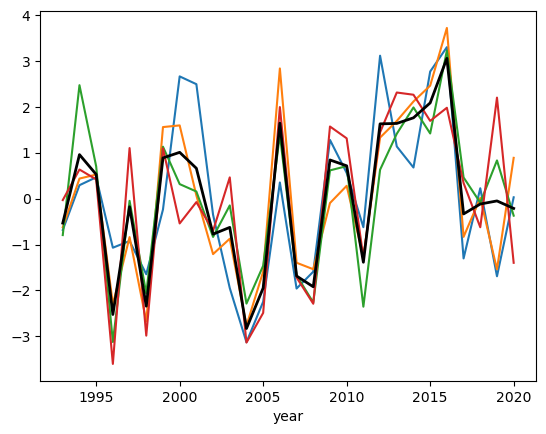

In [65]:
import matplotlib.pyplot as plt

year = da_cpi_ann_mean.year.data
for month in range(6,9+1):
     cpi_mon = da_cpi_mon_mean.where(da_cpi_mon_mean['month'] == month,drop=True).data
     plt.plot(year,cpi_mon)
da_cpi_ann_mean.plot(color='k',linewidth=2)

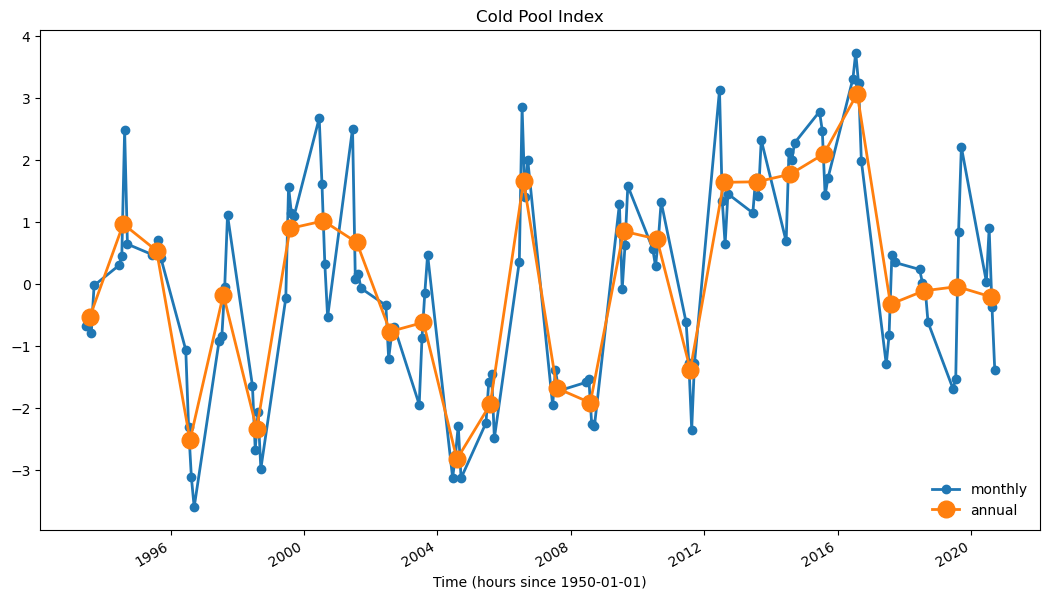

In [89]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[10,5])
ax1 = fig.add_axes([0,0,1,1])
linewidth = 2
markersize = 12
da_cpi_mon_mean.plot(marker='.',ax=ax1,linewidth=linewidth,markersize=markersize,label='monthly')
year_time = da_cpi_mon_mean.where(da_cpi_mon_mean['month'] == 8,drop=True).time.data-np.timedelta64(15, 'D')
ax1.plot(year_time,da_cpi_ann_mean.data,marker='o',linewidth=linewidth,markersize=markersize,label='annual')
ax1.set_title('Cold Pool Index')
ax1.legend(loc='lower right', frameon=False)

In [ ]:
# def plot_coldpool(pp_root, label):
#     model = open_var(pp_root, 'ocean_monthly', 'tob')
#     model_grid = xarray.open_dataset('../../data/geography/ocean_static.nc')    
#     hubert = xarray.open_dataarray('/net2/acr/hubert_bottom_temp/daily_bottom_temp_neus_1959_2019.nc')
#     mom_to_hubert = xesmf.Regridder(
#         model_grid[['geolon', 'geolat']].rename({'geolon': 'lon', 'geolat': 'lat'}),
#         hubert,
#         method='bilinear'
#     )
#     interpolated_depth = mom_to_hubert(model_grid.deptho)

#     # Use this period for climatology
#     ymin = int(model['time.year'].min())
#     ymax = int(model['time.year'].max())

#     # June-Sep average for each year
#     hubert_ave = hubert.sel(day=slice(152, 273), year=slice(1972, 2019)).mean('day')

#     # Long-term June-Sep average
#     hubert_climo = hubert_ave.mean('year')

#     # Create mask where long-term average and coordinates meet criteria
#     hubert_mask = ((hubert_climo < 10) & (interpolated_depth < 200) & (interpolated_depth > 20) & (hubert_climo.lat >= 38) & (hubert_climo.lat <= 41.5) & 
#     (hubert_climo.lon > -75) & (hubert_climo.lon < -68.5) & (hubert_climo > 6))
#     # Slice off the NE corner
#     hubert_mask = hubert_mask.where((hubert_mask.lat <= 41) | (hubert_mask.lon < -70)).fillna(0)

#     # Use a climatology that matches the model time period
#     hubert_matching_climo = hubert_ave.sel(year=slice(ymin, ymax)).mean('year')
#     hubert_cpi = (hubert_ave - hubert_matching_climo).where(hubert_mask).mean(['lat', 'lon'])
    
#     # Interpolate model bottom temperature to Hubert's grid
#     tbot_rg = mom_to_hubert(model)

#     # Model June-Sep average for each year
#     ave = tbot_rg.sel(time=np.logical_and(tbot_rg['time.month'] >= 6, tbot_rg['time.month'] <= 9)).resample(time='1AS').mean('time')

#     # Long-term June-Sep average
#     ltm = ave.mean('time')

#     # Model cold pool index
#     cpi = (ave - ltm).where(hubert_mask).mean(['lat', 'lon']).load()
#     cpi['time'] = cpi['time.year']

#     # Subtract model - obs over cold pool mask region
#     delta = ltm.where(hubert_matching_climo.notnull()) - hubert_matching_climo

#     fig = plt.figure(figsize=(10, 8), tight_layout=True)
#     gs = gridspec.GridSpec(2, 3, hspace=.2)
    
#     lonc, latc = corners(ltm.lon, ltm.lat)
#     levels = np.arange(4, 26.1, 2)
#     cmap, norm = get_map_norm('cmc.roma_r', levels, no_offset=True)
#     common = dict(cmap=cmap, norm=norm)
#     bias_levels = np.arange(-4, 4.1, 1)
#     bias_cmap, bias_norm = get_map_norm('coolwarm', bias_levels, no_offset=True)

#     ax = fig.add_subplot(gs[0, 0], projection=PC)
#     p = ax.pcolormesh(lonc, latc, ltm.where(hubert_matching_climo.notnull()), **common)
#     add_ticks(ax)
#     ax.set_extent([-76, -68, 35, 42])
#     ax.set_title('(a) Model')
#     cbar = autoextend_colorbar(plt, p, orientation='horizontal', label='Bottom temp. (°C)', pad=0.13)

#     ax = fig.add_subplot(gs[0, 1], projection=PC)
#     p = ax.pcolormesh(lonc, latc, hubert_matching_climo, **common)
#     add_ticks(ax)
#     ax.set_extent([-76, -68, 35, 42])
#     ax.set_title('(b) du Pontavice et al.')
#     cbar = autoextend_colorbar(plt, p, orientation='horizontal', label='Bottom temp. (°C)', pad=0.13)

#     ax = fig.add_subplot(gs[0, 2], projection=PC)
#     p = ax.pcolormesh(lonc, latc, delta, cmap=bias_cmap, norm=bias_norm)
#     cbar = autoextend_colorbar(plt, p, orientation='horizontal', label='Difference (°C)',  pad=0.13)
#     add_ticks(ax)
#     ax.set_extent([-76, -68, 35, 42])
#     ax.set_title('(c) Model - du Pontavice')
#     annotate_skill(
#         ltm.where(hubert_matching_climo.notnull()), 
#         hubert_matching_climo, 
#         ax, 
#         dim=['lat', 'lon'], 
#         fontsize=8,
#         x0=-72,
#         y0=37,
#         yint=0.5
#     ) # weights

#     ax = fig.add_subplot(gs[1, :])
#     cpi.plot(ax=ax, c='r', label='Model')
#     hubert_cpi.plot(ax=ax, c='k', label='du Pontavice et al.')
#     ax.set_xlim(1970, 2020)
#     ax.set_ylim(-3, 2)
#     ax.set_xlabel('')
#     ax.set_ylabel('Cold pool index (°C)')
#     ax.set_title('(d) June-September cold pool index')
#     ax.legend(frameon=False)
#     r = pd.concat([cpi.to_series(), hubert_cpi.to_series()], axis=1, keys=['model', 'obs']).corr().loc['model', 'obs']
#     ax.annotate(f'Corr: {r:2.2f}', (2013, -2.5))

#     save_figure('coldpool_eval', label=label, pdf=True, output_dir='../figures')

#     hubert_cpi.name = 'coldpool_index'
#     cpi.name = 'coldpool_index'
#     hubert_cpi.to_netcdf('../figures/obs_coldpool_index.nc')
#     if label == '':
#         cpi.to_netcdf(f'../figures/model_coldpool_index.nc')
#     else:
#         cpi.to_netcdf(f'../figures/{label}_coldpool_index.nc')